```
This notebook sets up and runs a test case for analyzing Kelvin waves
Copyright (C) 2018 - 2022 SINTEF Digital
Copyright (C) 2018 - 2022 Norwegian Meteorological Institute

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

In [1]:
import sys
gpuocean_path = [p[:-4] for p in sys.path if p.endswith("gpuocean/src")][0]
import git
repo = git.Repo(gpuocean_path)
print("GPUOcean code from:", repo.head.object.hexsha, "on branch", repo.active_branch.name)

GPUOcean code from: 50abfe851e13fd076f4f6ba635bc8d1fd9795536 on branch reduced_gravity


# Oslofjord
Testing of Nils projected files

In [2]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime, copy
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

plt.rcParams["image.origin"] = "lower"

In [3]:
from gpuocean.utils import IPythonMagic, Common, NetCDFInitialization, WindStress, OceanographicUtilities

In [4]:
%cuda_context_handler barotropic_gpu_ctx

In [5]:
%cuda_context_handler baroclinic_gpu_ctx

Path to the test file

In [6]:
source_url = "/sintef/data/OsloFjord/test_polstere_1h_0007.nc"

## Inspecting file structure and content

In [7]:
from netCDF4 import Dataset
nc = Dataset(source_url)

In [8]:
import xarray as xr
ds = xr.open_dataset(source_url)
ds

<xarray.Dataset>
Dimensions:     (ocean_time: 720, s_rho: 42, s_w: 43, eta_rho: 741, xi_rho: 397, xi_u: 396, eta_v: 740)
Coordinates:
  * ocean_time  (ocean_time) datetime64[ns] 2014-06-30T13:00:00 ... 2014-07-3...
  * s_rho       (s_rho) float64 -0.9881 -0.9643 -0.9405 ... -0.03571 -0.0119
  * s_w         (s_w) float64 -1.0 -0.9762 -0.9524 ... -0.04762 -0.02381 0.0
Dimensions without coordinates: eta_rho, xi_rho, xi_u, eta_v
Data variables: (12/15)
    projection  int32 ...
    Cs_r        (s_rho) float64 ...
    Cs_w        (s_w) float64 ...
    h           (eta_rho, xi_rho) float32 ...
    mask_rho    (eta_rho, xi_rho) float32 ...
    angle       (eta_rho, xi_rho) float32 ...
    ...          ...
    salt        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    temp        (ocean_time, s_rho, eta_rho, xi_rho) float32 ...
    u           (ocean_time, s_rho, eta_rho, xi_u) float32 ...
    v           (ocean_time, s_rho, eta_v, xi_rho) float32 ...
    lat_rho     (eta_rho, xi_rho) float32 ...
    lon_rho     (eta_rho, xi_rho) float32 ...

Animation utils

In [9]:
import animation_utils

## Generating GPUOcean Simulation from Input

General parameters

In [10]:
dimY, dimX = ds.h.data.shape

In [11]:
x0, x1, y0, y1 = 5, dimX-5, 175, dimY-5

In [12]:
t_start = 3*24
t_stop =  6*24

In [13]:
T = (t_stop-t_start)*3600  #Input

#### Barotropic Input

In [14]:
barotropic_data_args = NetCDFInitialization.getInitialConditions(source_url, x0, x1, y0, y1, timestep_indices=np.arange(t_start,t_stop), norkyst_data=False, land_value=0.0, download_data=False)
barotropic_data_args = NetCDFInitialization.removeMetadata(barotropic_data_args)

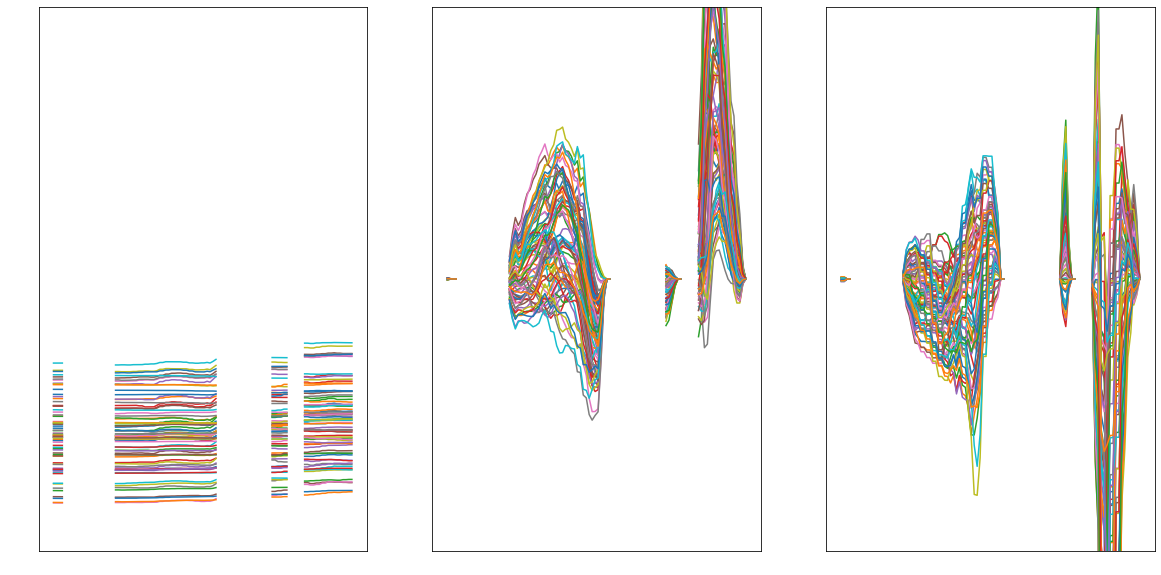

In [15]:
ncfile = Dataset(source_url)

eta = []
hu  = []
hv  = []

H_m = np.ma.array(ncfile["h"][y0:y1,x0:x1], mask=[1-ncfile["mask_rho"][y0:y1,x0:x1]])
integrator = NetCDFInitialization.MLD_integrator(source_url, H_m, x0=x0, x1=x1, y0=y0, y1=y1)

for t_idx in range(t_start, t_stop):

    eta.append( ncfile["zeta"][t_idx,y0:y1,x0:x1])

    u = 0.5*(ncfile["u"][t_idx,:,y0:y1,x0:x1]+ncfile["u"][t_idx,:,y0:y1,x0+1:x1+1])
    v = 0.5*(ncfile["v"][t_idx,:,y0:y1,x0:x1]+ncfile["v"][t_idx,:,y0+1:y1+1,x0:x1])
    
    hu.append( np.sum(integrator * u, axis=0) )
    hv.append( np.sum(integrator * v, axis=0) )

eta = np.ma.array(eta, mask = len(eta)*[1-ncfile["mask_rho"][y0:y1,x0:x1]])
hu  = np.ma.array(hu, mask = len(hu)*[1-ncfile["mask_rho"][y0:y1,x0:x1]])
hv  = np.ma.array(hv, mask = len(hv)*[1-ncfile["mask_rho"][y0:y1,x0:x1]])


fig, axs = plt.subplots(1,3, figsize=(20,10))
for t_idx in range(len(eta)): 
    axs[0].plot(eta[t_idx][0])
    axs[0].set_ylim((-0.5,0.5))
    axs[1].plot(hu[t_idx][0])
    axs[1].set_ylim((-5,5))
    axs[2].plot(hv[t_idx][0])
    axs[2].set_ylim((-5,5))

##### Baroclinic input

In [16]:
baroclinic_data_args = {}

In [17]:
import pyproj
proj_str = nc["projection"].proj4

proj = pyproj.Proj(proj_str)

lat_rho = nc.variables['lat_rho'][y0:y1, x0:x1]
lon_rho = nc.variables['lon_rho'][y0:y1, x0:x1]
x_rho, y_rho = proj(lon_rho, lat_rho, inverse = False)
x, y = x_rho[0], y_rho[:,0]

baroclinic_data_args['nx'] = (x1-x0)-4
baroclinic_data_args['ny'] = (y1-y0)-4

NX = baroclinic_data_args["nx"]+4
NY = baroclinic_data_args["ny"]+4

baroclinic_data_args['dx'] = np.average(x[1:] - x[:-1])
baroclinic_data_args['dy'] = np.average(y[1:] - y[:-1])

In [18]:
baroclinic_data_args['angle'] = nc["angle"][y0:y1, x0:x1]
baroclinic_data_args['latitude'] = OceanographicUtilities.degToRad(lat_rho)
baroclinic_data_args["f"] = 0.0

In [19]:
H = 0.0

H_m_data = nc.variables['h'][y0-1:y1+1, x0-1:x1+1]
H_m_mask = (H_m_data == 0.0)
H_m = np.ma.array(H_m_data, mask=H_m_mask)
H_i = OceanographicUtilities.midpointsToIntersections(H_m, land_value=0.0, iterations=10)[0]

baroclinic_data_args["H"] = np.ma.array(H*np.ones_like(H_i), mask=H_i.mask.copy(), dtype=np.float32)

In [20]:
mld = np.ma.array( 10.0*np.ones_like(H_m[1:-1,1:-1]), mask=[1-ncfile["mask_rho"][y0:y1,x0:x1]] )

init_mld_south = 5
init_mld_north = 10

mld.data[0:430] = init_mld_south*np.ones((430,mld.shape[1])) + (init_mld_north - init_mld_south)*np.ones((430,mld.shape[1]))*np.arange(0,1,1/430)[:,np.newaxis]
mld.data[430:] = init_mld_north
mld.data[:,235:] = init_mld_north
mld = NetCDFInitialization.fill_coastal_data(mld)

baroclinic_data_args["eta0"] = np.ma.array(mld.data - H, mask=copy.copy(mld.mask))

In [21]:
# Starting from lake at rest
baroclinic_data_args["hu0"] = np.ma.array(np.zeros_like(mld), mask=copy.copy(mld.mask))
baroclinic_data_args["hv0"] = np.ma.array(np.zeros_like(mld), mask=copy.copy(mld.mask))

In [22]:
baroclinic_data_args["g"] = 0.01

In [23]:
baroclinic_data_args["r"] = 3.0e-3

In [24]:
baroclinic_data_args['boundary_conditions'] = Common.BoundaryConditions(north=3, south=3, east=3, west=3, spongeCells={'north':20, 'south': 20, 'east': 20, 'west': 20})

In [25]:
t_step = 3600
T_steps = int(np.ceil(T/t_step)+1)

ts = np.arange(0, T+1, step=t_step)

ampl_v = 0.3 #Input
freq = 12*3600 
bc_v_ref = ampl_v * np.cos(2*np.pi*ts/freq)[:,np.newaxis] 

bc_v = np.zeros((T_steps, NX))
bc_v[:,165:] = np.ones((T_steps, NX-165)) * bc_v_ref

bc_h = 5*np.ones((T_steps,NX)) #np.tile(mld[0], (T_steps,1))

ampl_h = 3.0
bc_h[:,165:] = bc_h[:,165:] + ampl_h*np.ones_like(bc_h[:,165:])*np.cos(2*np.pi*ts/freq)[:,np.newaxis]

bc_hv = bc_h*bc_v

bc_h = bc_h - H

south = Common.SingleBoundaryConditionData(h=bc_h.astype(np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=bc_hv.astype(np.float32))
north = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NX), dtype=np.float32), hu=np.zeros((T_steps, NX), dtype=np.float32), hv=np.zeros((T_steps, NX), dtype=np.float32))
east  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))
west  = Common.SingleBoundaryConditionData(h=np.zeros((T_steps, NY), dtype=np.float32), hu=np.zeros((T_steps, NY), dtype=np.float32), hv=np.zeros((T_steps, NY), dtype=np.float32))

baroclinic_data_args["boundary_conditions_data"] = Common.BoundaryConditionsData(ts, north=north, south=south, east=east, west=west)

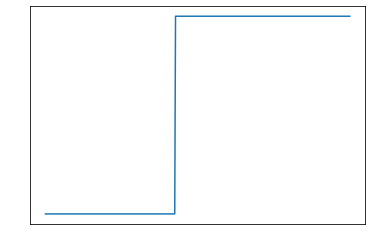

In [26]:
plt.plot( baroclinic_data_args["boundary_conditions_data"].south.h[0] )

In [27]:
wind_u_ref = np.zeros(24)
wind_u_ref[:10] = -0.5*(np.sin(2*np.pi*(np.arange(0,10)-2.5)/10)+1)
wind_u_ref[10:] = 5*(np.sin(2*np.pi*(np.arange(10,24)+0.5)/14)+1)

wind_angle = np.deg2rad(45.0)

wind_u = (np.int32(np.ceil((T_steps)/24)) * list(np.cos(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32)))[0:len(ts)]
wind_v = (len(wind_u) *list(np.sin(wind_angle)*wind_u_ref[:,np.newaxis][:,np.newaxis].astype(np.float32)))[0:len(ts)]

wind_scaling = 0.75*1e-5

wind_stress_u = copy.deepcopy(wind_u)
wind_stress_v = copy.deepcopy(wind_v)
for t_idx in range(len(wind_stress_u)):
    wind_stress_u[t_idx] = wind_scaling*wind_stress_u[t_idx]
    wind_stress_v[t_idx] = wind_scaling*wind_stress_v[t_idx]

baroclinic_data_args["wind"] = WindStress.WindStress(t=ts, stress_u=wind_stress_v, stress_v=wind_stress_u)
barotropic_data_args["wind"] = WindStress.WindStress(t=ts, stress_u=wind_stress_v, stress_v=wind_stress_u)

### Combined Simulation

Issues:
- IC and BC in both models should correspond to each other
- Same wind used for baroclinic and barotropic

In [28]:
from gpuocean.SWEsimulators import CombinedCDKLM16

sims = CombinedCDKLM16.CombinedCDKLM16(baroclinic_gpu_ctx, barotropic_gpu_ctx, dt=0.0, write_netcdf=True, **NetCDFInitialization.removeCombinedMetadata(barotropic_data_args, baroclinic_data_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


Combined Drifters

In [29]:
from gpuocean.utils import Observation
from gpuocean.drifters import GPUDrifterCollection
from gpuocean.dataassimilation import DataAssimilationUtils as dautils

In [30]:
observation_type = dautils.ObservationType.UnderlyingFlow 
    
observation_args = {'observation_type': observation_type,
                'nx': sims.nx, 'ny': sims.ny,
                'domain_size_x': sims.nx*sims.dx,
                'domain_size_y': sims.ny*sims.dy,
                'land_mask': sims.getLandMask()
                }

trajectories = Observation.Observation(**observation_args)
barotropic_trajectories = Observation.Observation(**observation_args)

In [31]:
initx = [ 6000]
inity = [12000]

num_drifters = len(initx)

drifters = GPUDrifterCollection.GPUDrifterCollection(sims.barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = sims.gpu_stream)

drifter_pos_init = np.array([initx, inity]).T
drifters.setDrifterPositions(drifter_pos_init)

In [32]:
barotropic_drifters = GPUDrifterCollection.GPUDrifterCollection(sims.barotropic_gpu_ctx, num_drifters,
                                                    boundaryConditions = sims.boundary_conditions,
                                                    domain_size_x = trajectories.domain_size_x,
                                                    domain_size_y = trajectories.domain_size_y,
                                                    gpu_stream = sims.gpu_stream)
barotropic_drifters.setDrifterPositions(drifter_pos_init)

In [33]:
sims.attachDrifters(drifters, barotropic_drifters=barotropic_drifters)
trajectories.add_observation_from_sim(sims)

In [34]:
for hour in range(24):
    sims.combinedStep(3600.0, trajectory_dt=60, trajectories=trajectories, barotropic_trajectories=barotropic_trajectories)

Plots

/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("Reds"))
  # Remove the CWD from sys.path while we load stuff.


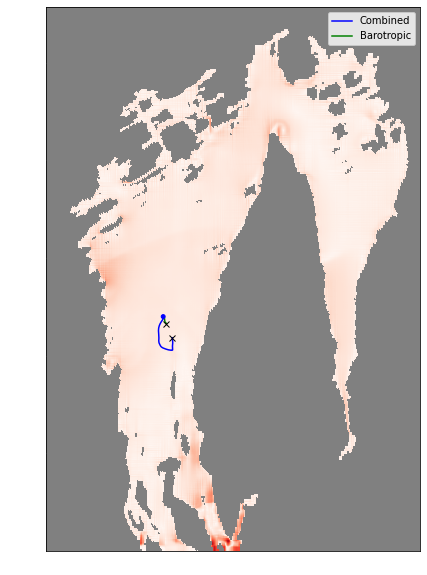

In [35]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

combined_eta, combined_u, combined_v = sims.download() 
uv_field = np.sqrt(combined_u**2 + combined_v**2)


domain_extent = [0, sims.nx*sims.dx, 0, sims.ny*sims.dy]

velo_cmap = copy.deepcopy(plt.cm.Reds)
velo_cmap.set_bad("grey", alpha = 1.0)

ax.imshow(uv_field, interpolation="none", origin='lower', 
                cmap=velo_cmap, 
                vmin=0.0, vmax=0.5, 
                extent=domain_extent)

drifter_path = trajectories.get_drifter_path(0, 0, sims.t, in_km = False)[0]
barotropic_drifter_path = barotropic_trajectories.get_drifter_path(0, 0, sims.t, in_km = False)[0]

start_pos = drifter_path[0,:]
circ_start = matplotlib.patches.Circle((start_pos[0], start_pos[1]), 
                                                100, color = 'blue',
                                                fill=True, zorder=10)
ax.add_patch(circ_start)

ax.plot(drifter_path[:,0], drifter_path[:,1], color="blue", ls="-", zorder=5, label="Combined")
end_pos = drifter_path[-1,:]
ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)

ax.plot(barotropic_drifter_path[:,0], barotropic_drifter_path[:,1], color="green", ls="-", zorder=5, label="Barotropic")
end_pos = barotropic_drifter_path[-1,:]
ax.plot(end_pos[0], end_pos[1], 'x', color='k', zorder=11)

ax.legend(labelcolor="black")


In [36]:
from gpuocean.utils.GPUOcean_runDeterministic import * 

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))
from utils.utilsOpenDrift import *

In [37]:
from importlib import reload
reload(animation_utils)

<module 'animation_utils' from '/home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/Oslofjord/animation_utils.py'>

In [38]:
lon, lat = xygpuocean2lonlat(source_url, initx, inity, x0, y0)
oceandrift = simulate_opendrift(source_url, lat= lat, lon= lon, velocity_average=False) #no wind
opendrift_trajectories = opendriftObj2gpuoceanObs(oceandrift, x0, x1, y0, y1, source_url)

Exception caught: Resetting to CUDA context baroclinic_gpu_ctx
Traceback (most recent call last):
  File "/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1228203/689675038.py", line 1, in <module>
    lon, lat = xygpuocean2lonlat(source_url, initx, inity, x0, y0)
  File "/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py", line 150, in xygpuocean2lonlat
    X, Y, proj = getXYproj(source_url)
  File "/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py", line 37, in getXYproj
    raise e
  File "/home/florianb/havvarsel/gpuocean/src/gpuocean/utils/GPUOcean_runDeterministic.py", line 32, in getXYproj
    var = ncfile.variables['projection_stere']
KeyError: 'projection_stere'


KeyError: 'projection_stere'